# MSIBI: Simple Tutorial

### Purpose

This tutorial will illustrate the process of stringing together multiple instances of msibi optimization runs. It is common for IBI and MSIBI methods to optimize forces in order of their relative strength, which typically means bond stretching is optimized first, followed by bond angles, then non-bonded pairs and dihedrals, where the potential learned from the previous step is included in the next optimization. The API for msibi is designed to make it straight-forward to follow this process. This tutorial is split into three sections:

1) Using a target trajectory of a single-chain simulation, an `msibi.Bond` force is optimized without including any additional forces. 
2) Using the same target trajectory, an `msibi.Angle` force is optimized. This optimization includes setting a harmonic bond-stretching force where the parameters were obtained from step 1.
3) Using a target trajectory of a "bulk system" of oligomers, an `msibi.Pair` force is optimized. This includes setting a table potential for angle interactions (obtained from step 2) and a harmonic potential for bond-stretching (obtained from step 1).

Before running this tutorial, see the installation section of the documentation to ensure you have the software environment needed to run this notebook.

### A note about MSIBI's parameters:

There are several hyper-parameters available in MSIBI that can significantly affect the outcome of the final potentials. These include things such as sampling sizing and frequency (`msibi.State.n_frames` and `msibi.State.sampling_stride`), the alpha value used in weighting state points and dampening potnetial corrections (`msibi.State.alpha0`), as well as smoothing choices such as how often to smooth the learned potential (e.g., between each MSIBI iteration, or only once at the end), smoothing window and order (`msibi.Force.smoothing_window` and `msibi.Force.smoothing_order`). Therefore, when using MSIBI on your own systems, it is important to explore these parameters and understand the impact it can have on the final outcome.

Because of differences in software environments, it might be the case that your outputs differ from those shown in these examples. Try changing some of these parameters to see how it affects the final potentials and distribution matching.

### Target Trajectories

These examples use target simulations of simple Lennard-Jones (LJ) bead-spring models. In other words, these are already coarse-grained simulations, and the examples below "learn" the potential that was used in these target simulations. This is different from most applications of MSIBI, where the target trajectories are atomistic simulations that have had a coarse-grained mapping applied. In these cases, the coarse-grain potential is not known ahead of time, and the correctness of the learned potnetial is determined not just by structure-matching performance--which MSIBI optimizes against--but also other properties and behavior depending on the underlying systems and applications. To summarize, these examples suffice to illustrate the user interface and general process of using MSIBI to learn a coarse-grained forcefield, and using these simple systems allow this tutorial to do this without having to deal with complications from coarse-graining atomistic systems.

The target simulations used the following model:

Lennard Jones spheres are connected by harmonic bonds with the following interactions:


- $V_{bond}(l) = 0.5k_{l}(l - l_0)^2$
  
- $V_{angle}(\theta) = 0.5k_{\theta}(\theta - \theta_0)^2$

- $V_{nb}(r) = 4\epsilon\left[\left(\dfrac{\sigma}{r}\right)^{12} - \left(\dfrac{\sigma}{r}\right)^6\right]$

with:

| Parameter | Value | Description                                 |
|-----------|-------|---------------------------------------------|
| $k_l$       | 500 | Bond-stretching force constant              |
| $l_0$       | 1.1 | Equilibrium bond length                     |
| $k_{\theta}$ | 250 | Bond-bending force constant                |
| $\theta_0$  | 2.0 | Equilibrium bond angle                      |
| $\epsilon$  | 1.0 | Depth of non-bonded potential energy well   |
| $\sigma$    |1.0  | Particle radius                             |

Bonds and angles are learned from a single chain of 20 beads in a low density box (i.e., vacuum) while pairs are learned from a "bulk" system of 50 oligomers with 6 beads each.

In [1]:
import importlib.resources
import os

from msibi import State, Bond, Angle, Pair, MSIBI
import hoomd
import matplotlib.pyplot as plt
import numpy as np

import warnings

warnings.filterwarnings("ignore")

with importlib.resources.path(
    "msibi.tests.validation", "target_data", "chains"
) as target_dir:
    target_data_dir = target_dir

----------------------------------------
## 1) Optimizing a bond-stretching potential:

We will use a target trajectory consisting of a single chain simulation with a Lennard-Jones bead-spring model.


### Preparing all of the classes needed to run MSIBI:

In this cell we make the following:
- `msibi.MSIBI`: Object which acts as the context manager for the rest of the workflow.
    - Here, we set the simulation methods (NVT), thermostat (MTTK) and neighborlist (Cell) to use.
    - We provide additional parameters of time step (dt), thermostat coupling constant (tau), and trajectory write out frequency (gsd_period).
    - These set the methods used during coarse-grained query simulations, and the write out frequency effects sampling results of distributions.


- `msibi.State`: Object which stores the target trajectory, state point information (temperature), and sampling information (n_frames, sampling stride)
    - Here we set information about the target trajectory such as the path to the target .gsd file, the temperature (kT) of the target trajectory, and state point name.
    - Parameters that are used for sampling the distributions are set here such as number of frames (n_frames), and step size between sampled frames (sampling_stride).
    - Finally, the state-point weighting factor (alpha), or in the case of a single-state point the damping factor, is set.  


- `msibi.Force` Object which provides forces used in the coarse-grained query simulations.
    - Here, we only include one bond-stretching force (`msibi.Bond`), which is also the force being optimized (`optimize=True`).
    - It is required to set an initial potential to use during MSIBI iterations. Here, we use the `set_polynomial` method where we create a harmonic bond-stretching potential with initial parameters of $x_0 = 1.3\sigma$, $k2 = 200 \epsilon$, $k3=0$, and $k4=0$. By setting $k3$ and $k4$ to zero, this results in an initial "guess" potential of $V(x) = 200(x-1.3)^2$

In [6]:
# Remove the states directory created by the previous run
!rm -r states/

optimizer = MSIBI(
    nlist=hoomd.md.nlist.Cell,
    integrator_method=hoomd.md.methods.ConstantVolume,
    thermostat=hoomd.md.methods.thermostats.MTTK,
    thermostat_kwargs={"tau": 0.1},
    method_kwargs={},
    dt=0.0001,
    gsd_period=5000,
)

state = State(
    name="single-chain",
    kT=4.0,
    traj_file=os.path.join(str(target_data_dir), "single-chain.gsd"),
    n_frames=100,
    sampling_stride=2,
    alpha0=0.5,
)

bond = Bond(
    type1="A",
    type2="A",
    optimize=True,
    nbins=60,
    smoothing_window=5,
    correction_fit_window=7,
    smoothing_order=2,
)
bond.set_polynomial(x_min=0.0, x_max=2.5, x0=1.3, k2=200, k3=0, k4=0)

optimizer.add_state(state)
optimizer.add_force(bond)

Let's look at the target bond-length distribution, which is automatically calcualted with the given 

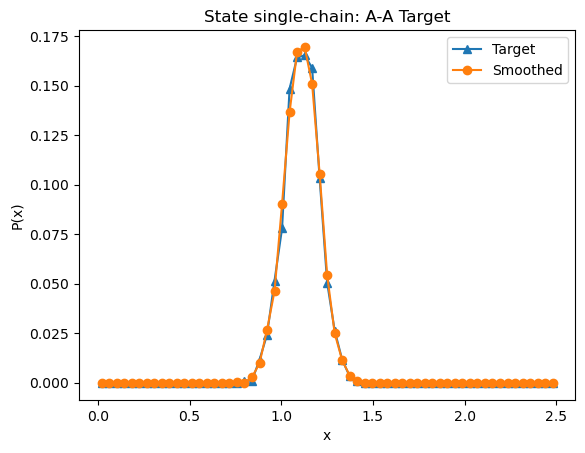

In [7]:
bond.plot_target_distribution(state=state)

In [8]:
optimizer.run_optimization(n_iterations=7, n_steps=1e6, backup_trajectories=False)
bond.smooth_potential()

---Optimization: 1 of 7---
Starting simulation 0 for state <class 'msibi.state.State'>; Name: single-chain; kT: 4.0; Alpha0: 0.5
Running on device <hoomd.device.GPU object at 0x7f194842b4d0>
Finished simulation 0 for state <class 'msibi.state.State'>; Name: single-chain; kT: 4.0; Alpha0: 0.5

Force: A-A, State: single-chain, Iteration: 0, Fit score:0.316331

---Optimization: 2 of 7---
Starting simulation 1 for state <class 'msibi.state.State'>; Name: single-chain; kT: 4.0; Alpha0: 0.5
Running on device <hoomd.device.GPU object at 0x7f19483cd940>
Finished simulation 1 for state <class 'msibi.state.State'>; Name: single-chain; kT: 4.0; Alpha0: 0.5

Force: A-A, State: single-chain, Iteration: 1, Fit score:0.595890

---Optimization: 3 of 7---
Starting simulation 2 for state <class 'msibi.state.State'>; Name: single-chain; kT: 4.0; Alpha0: 0.5
Running on device <hoomd.device.GPU object at 0x7f19483cd5b0>
Finished simulation 2 for state <class 'msibi.state.State'>; Name: single-chain; kT: 4.

### Examining the results

- Here we will view the evolution of the potential obtained from MSIBI (`bond.plot_potential_history`)
- Compare against the known potential used
- Compare the target bond-length distribution against the distribution obtained from MSIBI.

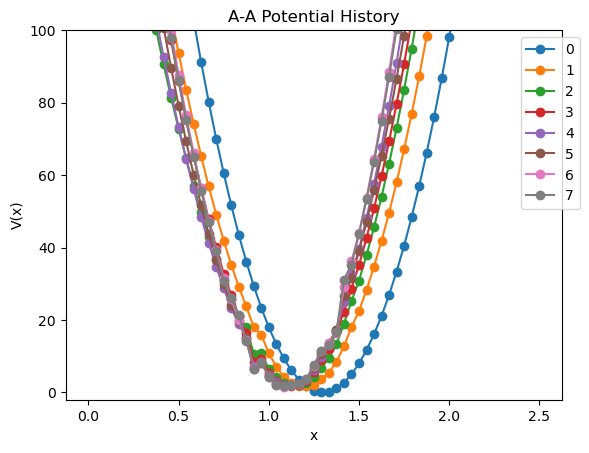

In [9]:
bond.plot_potential_history(ylim=(-2, 100))

In most cases, the coarse-grained potential is not known ahead of time (hence the need for MSIBI, and other coarse-graining methods). However, for the purposes of this tutorial, we know that the target trajectory obtained from a simulation using a harmonic bond-stretching potential with the form of:

$V(x) = \frac{1}{2}k(x - x_0)^2$

where the parameters used were $k=500$ and $x_0 = 1.1 \sigma$. Below, we plot the final potential obtained from MSIBI against the known potential, and see that MSIBI was able to recover the bond-stretching potential purely from iterative adjustments in formed by comparisons between bond-length distributions.

Text(0, 0.5, 'Energy $[\\epsilon]$')

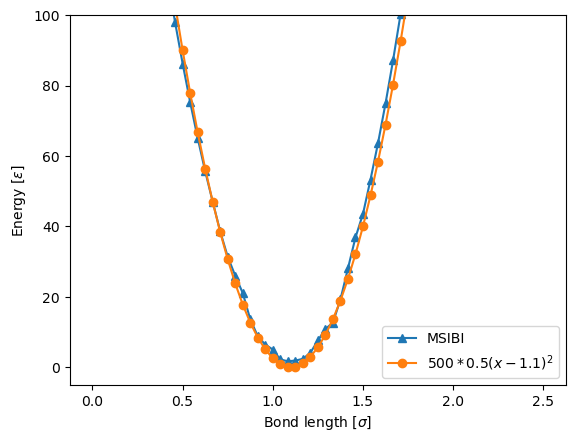

In [10]:
plt.plot(bond.x_range, bond.potential, label="MSIBI", marker="^")
plt.plot(
    bond.x_range,
    500 / 2 * (bond.x_range - 1.1) ** 2,
    label="$500 * 0.5(x-1.1)^2$",
    marker="o",
)
plt.ylim(-5, 100)
plt.legend()
plt.xlabel("Bond length [$\sigma$]")
plt.ylabel("Energy $[\epsilon]$")

Here, we can compare the final bond-length distribution obtained from MSIBI against the target

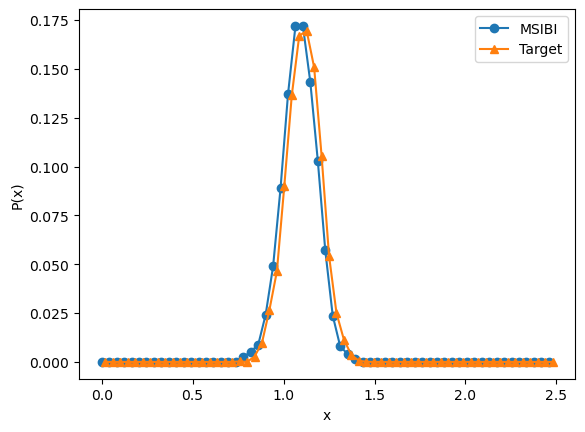

In [12]:
bond.plot_distribution_comparison(state=state)

----------------------------------------
## 2) Optimizing a bond-bending potential:

Many of the steps in this section are the same as in (1) optimizing bonds. However, there are a few differences.

- We use the `set_harmonic` method for the `A-A` bond. We could have saved the table potential from the last step and used `set_from_file` to create the A-A bond potential, but this illustrates another option for setting the potential for a `Force` object. In this case, the potential obtained from MSIBI fits nicely to a supported bond-stretching potential in HOOMD-Blue, so we opt to use this instead. Note, that `optimize=False` is now used for the `Bond` force.
  
- An `msibi.Angle` force is introduced, and the `set_polynomial` method is used to create an initial guess potential.

- After optimization is finished, the table potential file is saved to a .csv file with `angle.save_potential("AAA_angle_potential.csv")`. This will be used in the next step.

In [15]:
# Remove the states directory created by the previous run
!rm -r states/

optimizer = MSIBI(
    nlist=hoomd.md.nlist.Cell,
    integrator_method=hoomd.md.methods.ConstantVolume,
    thermostat=hoomd.md.methods.thermostats.MTTK,
    thermostat_kwargs={"tau": 0.1},
    method_kwargs={},
    dt=0.0001,
    gsd_period=5000,
)

state = State(
    name="single-chain",
    kT=4.0,
    traj_file=os.path.join(str(target_data_dir), "single-chain.gsd"),
    n_frames=100,
    sampling_stride=2,
    alpha0=0.5,
)

bond = Bond(type1="A", type2="A", optimize=False)
bond.set_harmonic(k=500, r0=1.1)

angle = Angle(
    type1="A",
    type2="A",
    type3="A",
    optimize=True,
    nbins=60,
    smoothing_window=5,
    correction_fit_window=7,
    smoothing_order=3,
)
angle.set_polynomial(x_min=0.0, x_max=np.pi, x0=2.3, k2=80, k3=0, k4=0)

optimizer.add_state(state)
optimizer.add_force(bond)
optimizer.add_force(angle)

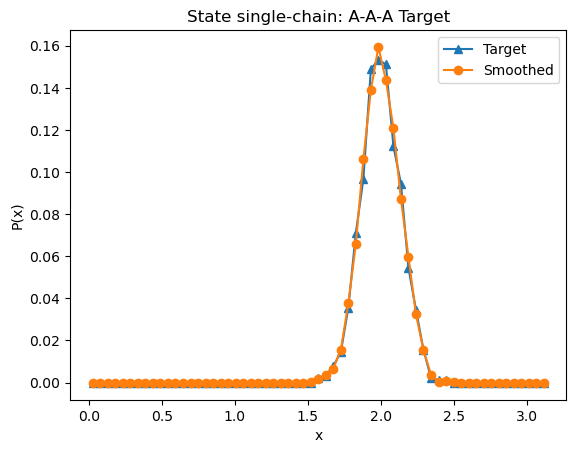

In [16]:
angle.plot_target_distribution(state=state)

In [17]:
optimizer.run_optimization(n_iterations=8, n_steps=1e6, backup_trajectories=False)
angle.smooth_potential()

---Optimization: 1 of 8---
Starting simulation 0 for state <class 'msibi.state.State'>; Name: single-chain; kT: 4.0; Alpha0: 0.5
Running on device <hoomd.device.GPU object at 0x7f19483d2e50>
Finished simulation 0 for state <class 'msibi.state.State'>; Name: single-chain; kT: 4.0; Alpha0: 0.5

Force: A-A-A, State: single-chain, Iteration: 0, Fit score:0.360769

---Optimization: 2 of 8---
Starting simulation 1 for state <class 'msibi.state.State'>; Name: single-chain; kT: 4.0; Alpha0: 0.5
Running on device <hoomd.device.GPU object at 0x7f1955d7eb70>
Finished simulation 1 for state <class 'msibi.state.State'>; Name: single-chain; kT: 4.0; Alpha0: 0.5

Force: A-A-A, State: single-chain, Iteration: 1, Fit score:0.638484

---Optimization: 3 of 8---
Starting simulation 2 for state <class 'msibi.state.State'>; Name: single-chain; kT: 4.0; Alpha0: 0.5
Running on device <hoomd.device.GPU object at 0x7f1955d7f2f0>
Finished simulation 2 for state <class 'msibi.state.State'>; Name: single-chain; kT

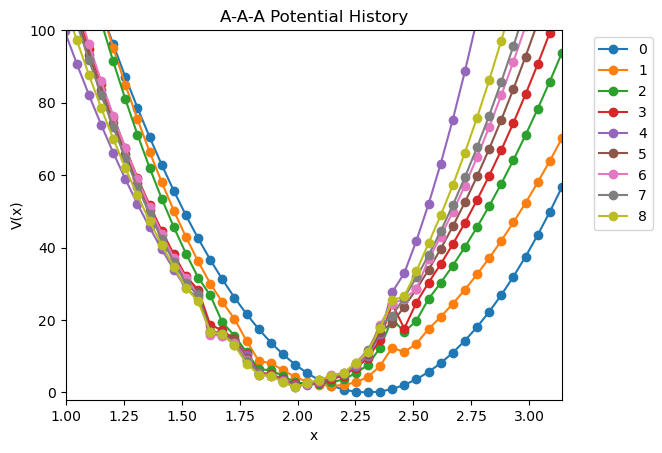

In [18]:
angle.plot_potential_history(ylim=(-2, 100), xlim=(1, np.pi))

Text(0, 0.5, 'Energy $[\\epsilon]$')

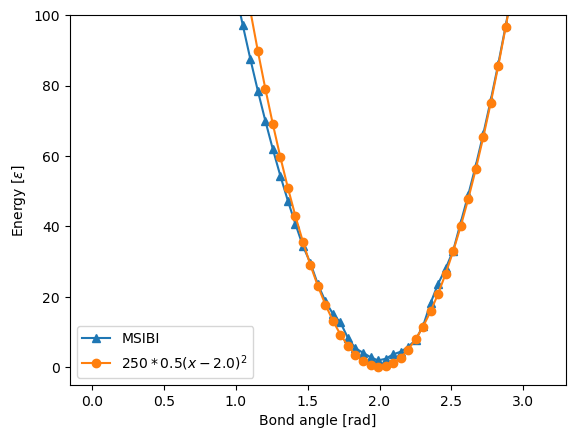

In [19]:
plt.plot(angle.x_range, angle.potential, label="MSIBI", marker="^")
plt.plot(
    angle.x_range,
    250 / 2 * (angle.x_range - 2.0) ** 2,
    label="$250 * 0.5(x-2.0)^2$",
    marker="o",
)
plt.ylim(-5, 100)
plt.legend()
plt.xlabel("Bond angle [rad]")
plt.ylabel("Energy $[\epsilon]$")

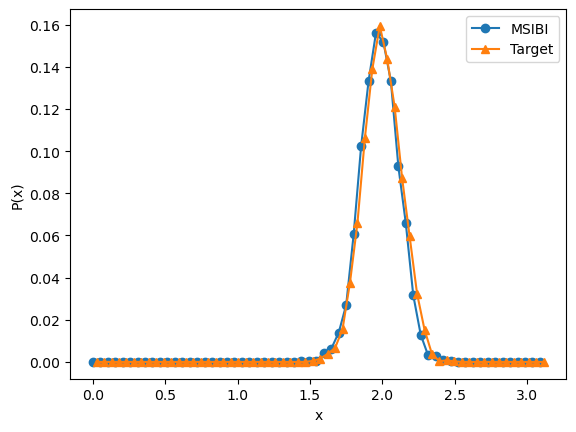

In [20]:
angle.plot_distribution_comparison(state=state)

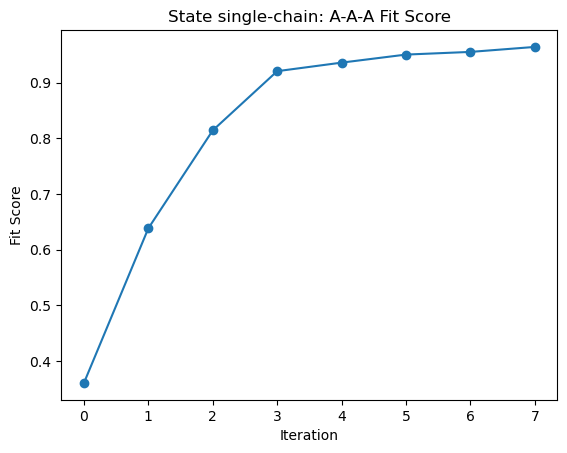

In [23]:
angle.plot_fit_scores(state=state)

For this example, we will use the `save_potential` method to create a .csv file of the derived angle potential.

In [24]:
angle.save_potential("AAA_angle_potential.csv")

## 3) Optimizing a pair potential

Here, we learn the non-bonded pair potential from a target simulation of a "bulk" system containing 50 chains with 6 beads each. We follow the same procedure as the previous step to set the bond-stretching potential, use then use the `set_from_file()` method to set a bond angle table potential obtained in the previous step.

In [31]:
# Remove the states directory created by the previous run
!rm -r states/

optimizer = MSIBI(
    nlist=hoomd.md.nlist.Cell,
    integrator_method=hoomd.md.methods.ConstantVolume,
    thermostat=hoomd.md.methods.thermostats.MTTK,
    thermostat_kwargs={"tau": 0.1},
    method_kwargs={},
    dt=0.0001,
    gsd_period=1000,
    nlist_exclusions=["bond", "angle"],
)

kT = 3.0
state = State(
    name=f"{kT}kT",
    kT=kT,
    traj_file=os.path.join(str(target_data_dir), "3.0kT.gsd"),
    n_frames=200,
    sampling_stride=4,
    alpha0=0.7,
    exclude_bonded=True,
)

bond = Bond(type1="A", type2="A", optimize=False)
bond.set_harmonic(k=500, r0=1.1)
angle = Angle(type1="A", type2="A", type3="A", optimize=False)
angle.set_from_file(file_path="AAA_angle_potential.csv")

pair = Pair(
    type1="A",
    type2="A",
    optimize=True,
    r_cut=2.5,
    nbins=80,
    smoothing_window=11,
    smoothing_order=2,
    r_switch=1.5,
    correction_fit_window=7,
)
pair.set_lj(r_min=0.1, r_cut=2.5, epsilon=0.8, sigma=1.2)

optimizer.add_state(state)
optimizer.add_force(bond)
optimizer.add_force(angle)
optimizer.add_force(pair)

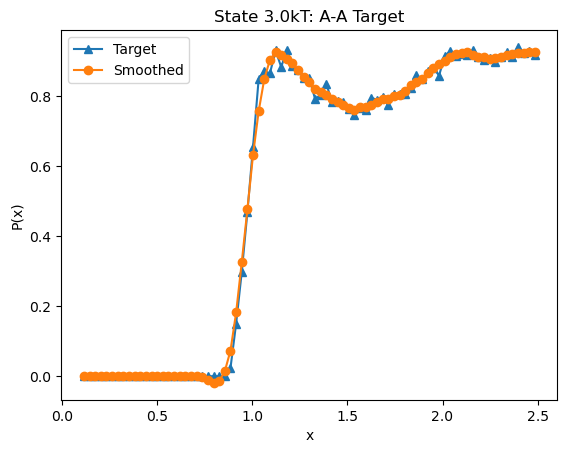

In [32]:
pair.plot_target_distribution(state=state)

In [33]:
for i in range(6):
    optimizer.run_optimization(n_iterations=1, n_steps=5e5, backup_trajectories=False)
    pair.smooth_potential()

---Optimization: 1 of 1---
Starting simulation 0 for state <class 'msibi.state.State'>; Name: 3.0kT; kT: 3.0; Alpha0: 0.7
Running on device <hoomd.device.GPU object at 0x7f1948437550>
Finished simulation 0 for state <class 'msibi.state.State'>; Name: 3.0kT; kT: 3.0; Alpha0: 0.7

Force: A-A, State: 3.0kT, Iteration: 0, Fit score:0.915179

---Optimization: 1 of 1---
Starting simulation 1 for state <class 'msibi.state.State'>; Name: 3.0kT; kT: 3.0; Alpha0: 0.7
Running on device <hoomd.device.GPU object at 0x7f1abc901b70>
Finished simulation 1 for state <class 'msibi.state.State'>; Name: 3.0kT; kT: 3.0; Alpha0: 0.7

Force: A-A, State: 3.0kT, Iteration: 1, Fit score:0.952345

---Optimization: 1 of 1---
Starting simulation 2 for state <class 'msibi.state.State'>; Name: 3.0kT; kT: 3.0; Alpha0: 0.7
Running on device <hoomd.device.GPU object at 0x7f1abc901e80>
Finished simulation 2 for state <class 'msibi.state.State'>; Name: 3.0kT; kT: 3.0; Alpha0: 0.7

Force: A-A, State: 3.0kT, Iteration: 2, 

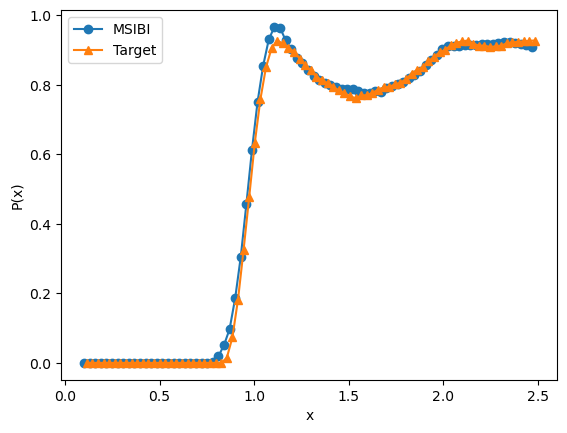

In [34]:
pair.plot_distribution_comparison(state=state)

In [35]:
from msibi.utils.potentials import lennard_jones

Text(0.5, 0, 'Distance $[\\sigma]$')

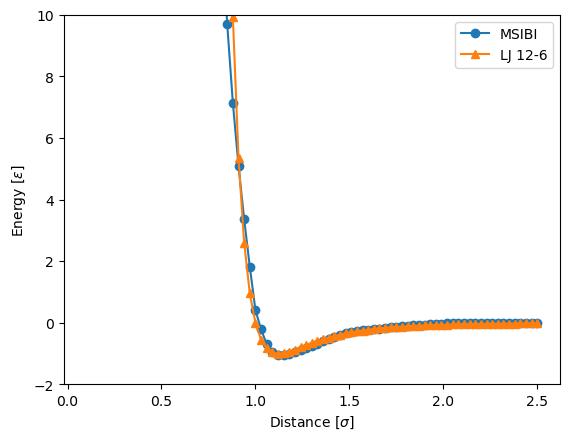

In [36]:
plt.plot(pair.x_range, pair.potential, "o-", label="MSIBI")
plt.plot(
    pair.x_range,
    lennard_jones(r=pair.x_range, epsilon=1, sigma=1),
    "^-",
    label="LJ 12-6",
)
plt.ylim(-2, 10)
plt.legend()
plt.ylabel("Energy $[\epsilon]$")
plt.xlabel("Distance $[\sigma]$")

-----------------------------------------------------